In [1]:
# ============================================
# || import all necessary libraries         ||
# ============================================

import numpy as np
#import matplotlib.pyplot as plt
import random
import time
#from typing import Dict, List, Tuple, Any
#import sys
#import os

# Utilities
from utils.data import get_fixed_data
from utils.visualization import plot_results, plot_experiment_results, plot_cost_histogram, compare_policies

# Task 0
## Liv har code som er brugt til de to scenarier

Optimal cost: 787.72


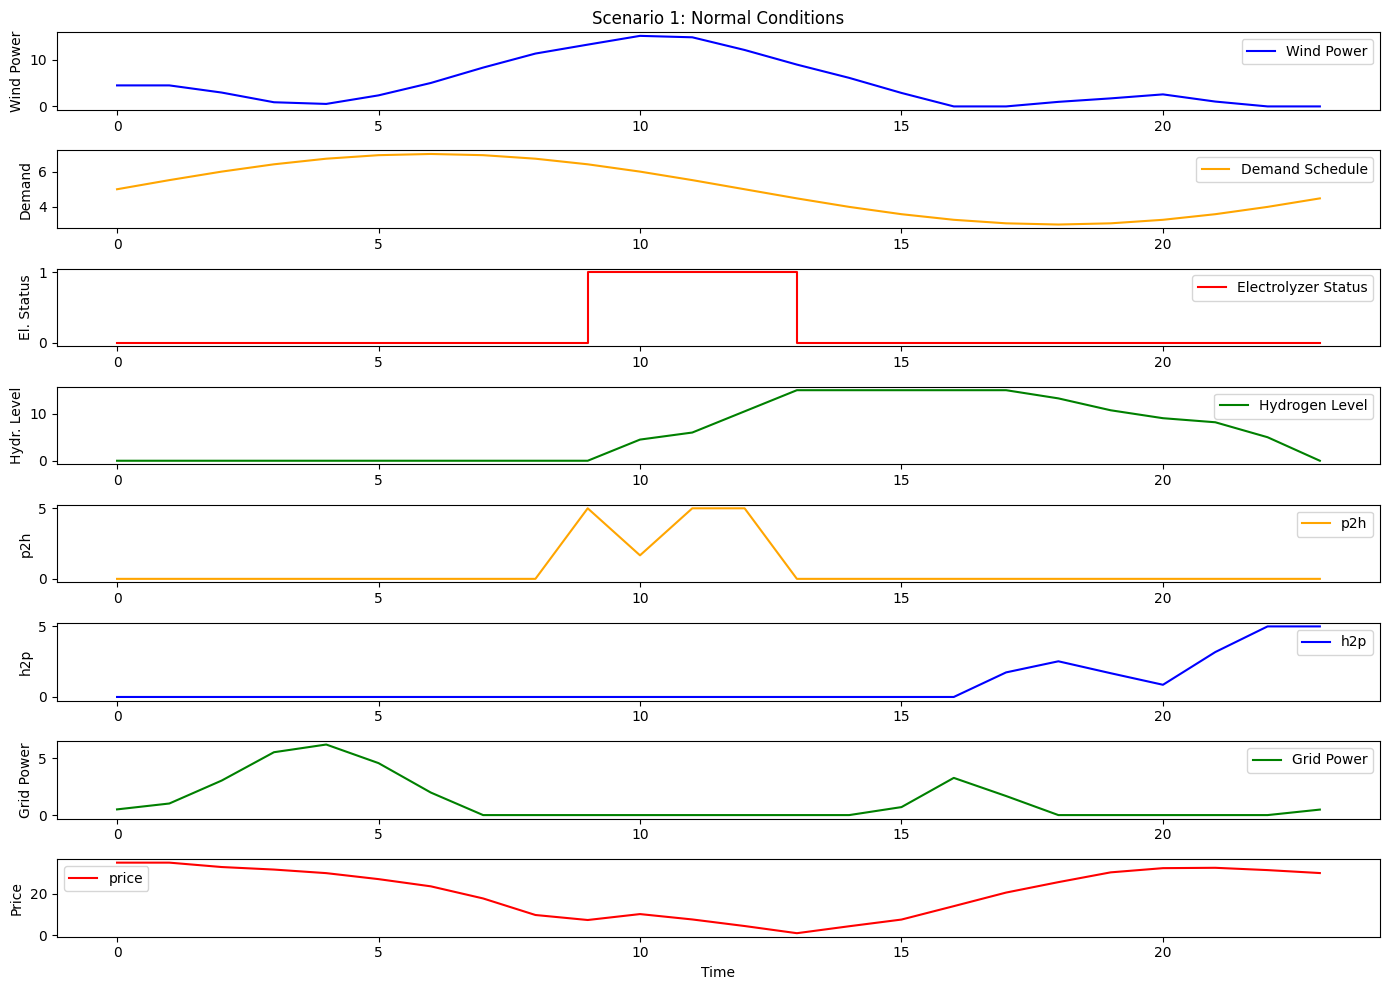

Optimal cost: 56.67


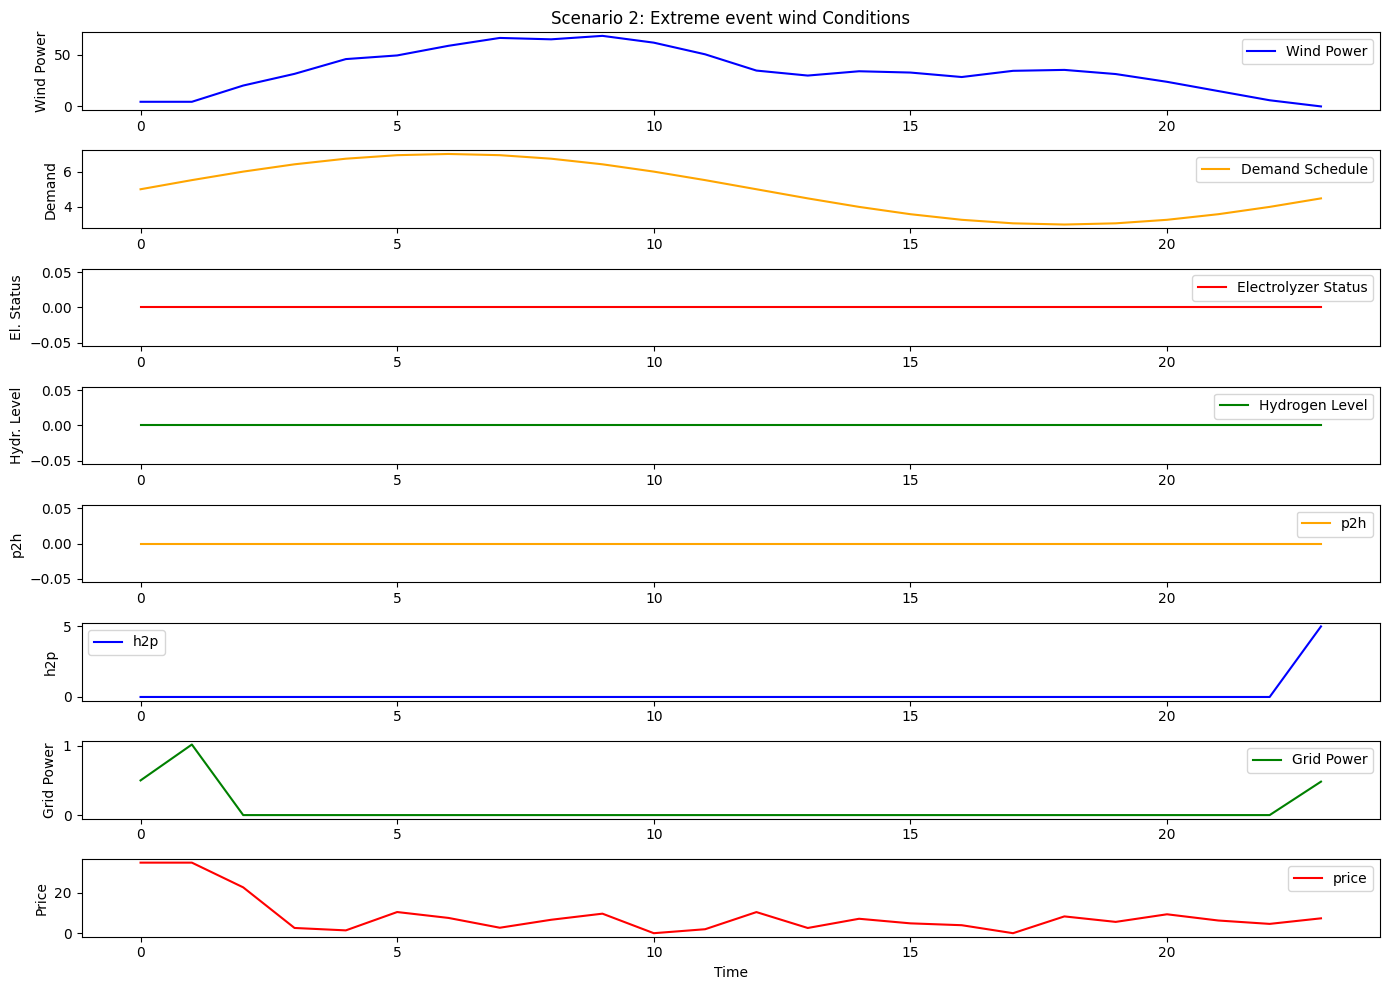

In [2]:
from task_0.helper_functions import generate_trajectories, solve_milp

def main() -> None:
    data = get_fixed_data()
    
    # First scenario - Normal conditions
    wind1, price1 = generate_trajectories(data)
    results1 = solve_milp(wind1, price1, data, False)
    plot_results(wind1, price1, results1, data, "Scenario 1: Normal Conditions")

    # Second scenario - More volatile conditions?
    data_volatile = data.copy()
    data_volatile['extreme_event_prob_wind'] = 0.8

    wind2, price2 = generate_trajectories(data_volatile)
    results2 = solve_milp(wind2, price2, data, False)
    plot_results(wind2, price2, results2, data, "Scenario 2: Extreme event wind Conditions")
random.seed(42)
main()

# Task 1

ENERGY HUB MDP EVALUATION

Evaluating Dummy Policy over 20 experiments...
Processing experiment 0...
Processing experiment 5...
Processing experiment 10...
Processing experiment 15...
Average policy cost: 771.71
Min cost: 137.59, Max cost: 2181.29
Dummy Policy Results:
Average Cost: 771.71
Min Cost: 137.59
Max Cost: 2181.29
Evaluation Time: 0.00 seconds

Generating visualizations...

Generating visualizations for Dummy Policy...


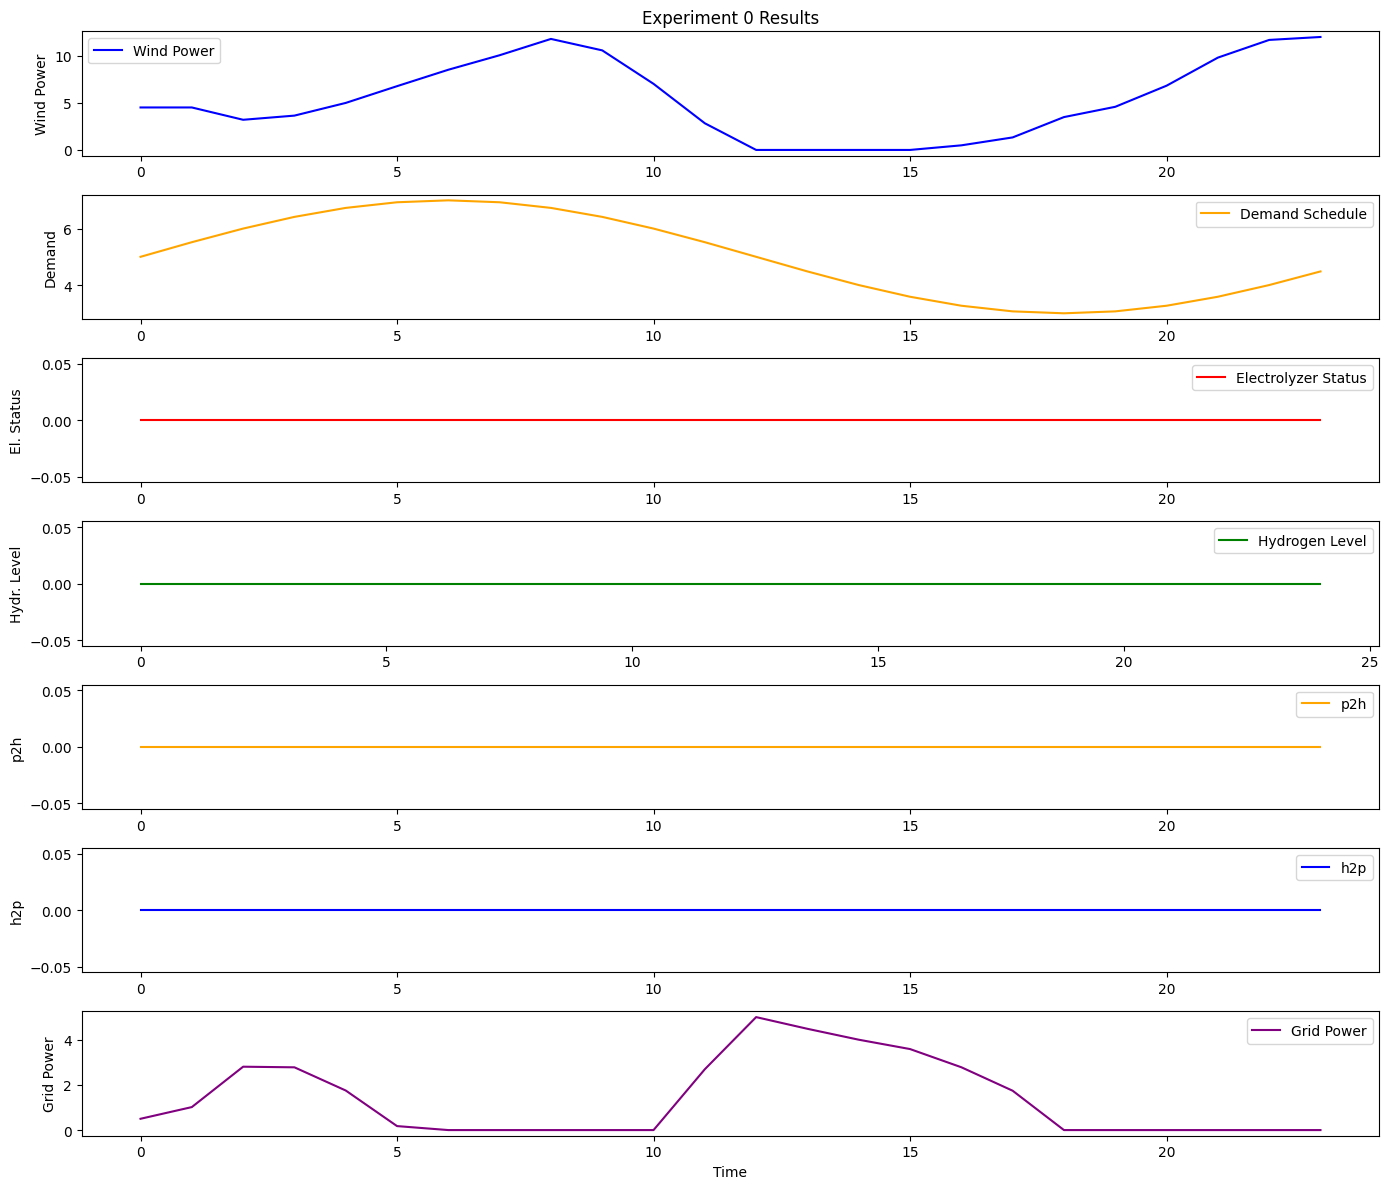

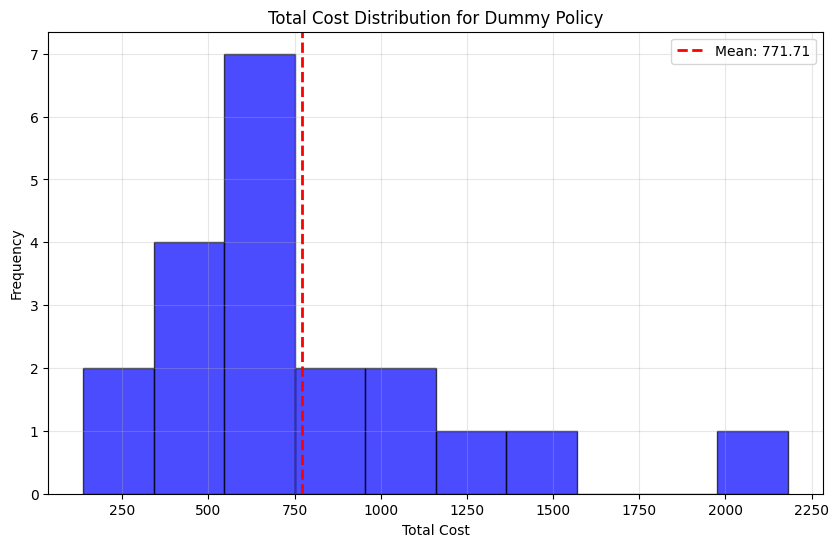


Evaluation completed successfully!


In [3]:
from task_1.evaluation_framework import evaluate_policy, create_experiments
from task_1.energy_hub_policies import dummy_policy


def main():
    data = get_fixed_data()
    
    print("=" * 50)
    print("ENERGY HUB MDP EVALUATION")
    print("=" * 50)
    num_experiments = 20
    policy_results = {}
    policies = {
        "Dummy Policy": dummy_policy
    }
    expers, wind_trajectories, price_trajectories = create_experiments(num_experiments, data)
    # Evaluate each policy
    for policy_name, policy_func in policies.items():
        print(f"\nEvaluating {policy_name} over {num_experiments} experiments...")
        start_time = time.time()
        
        avg_cost, results = evaluate_policy(policy_func,data, expers, wind_trajectories, price_trajectories, num_experiments, _debug=True)
        #avg_cost, results = evaluate_policy(policy_func, num_experiments=num_experiments)
        
        elapsed_time = time.time() - start_time
        
        print(f"{policy_name} Results:")
        print(f"Average Cost: {avg_cost:.2f}")
        print(f"Min Cost: {np.min(results['total_costs']):.2f}")
        print(f"Max Cost: {np.max(results['total_costs']):.2f}")
        print(f"Evaluation Time: {elapsed_time:.2f} seconds")
        
        # Store the results
        policy_results[policy_name] = results
    
    print("\nGenerating visualizations...")
    
    for policy_name, results in policy_results.items():
        print(f"\nGenerating visualizations for {policy_name}...")
        
        plot_experiment_results(results, experiment_index=0, data=data) # just the first experiment
        
        plot_cost_histogram(results, policy_name=policy_name) # histogram of total costs over all experiments
    
    print("\nEvaluation completed successfully!")
    
    return policy_results

if __name__ == "__main__":
    policy_results = main()

# Task 2

'wind_power': 5,

'wind_power_previous': 4,

'price': 30,

'price_previous': 28,

when in t =23 and H = 3 we do not shrink this. Eventhouh this is best practice

In [8]:
from task_2.helper_functions import create_ev_policy, create_sp_policy
def main():
    data = get_fixed_data()
    
    print("=" * 70)
    print("TASK 2: STOCHASTIC PROGRAMMING POLICIES FOR ENERGY HUB MANAGEMENT")
    print("=" * 70)
    
    # Is this enough?
    num_experiments = 20
    
    policy_results = {} # store results
    oih_results = {}
    # Total variables ≈ V × L × B^(L-1)×2
    # V = Number of variable types (in this case, 5 main decision variables)
    # L = Lookahead horizon length
    # B = Number of branches at each stage
    # 2 = Number of uncertain parameters (wind and price)
    ev_policy_config = create_ev_policy(horizon=3, num_samples=1000)
    sp_policy_config1 = create_sp_policy(horizon=5, branches_per_stage=2)   # (800)
    sp_policy_config2 = create_sp_policy(horizon=3, branches_per_stage=5)   # (750)
    sp_policy_config3 = create_sp_policy(horizon=2, branches_per_stage=12)  # (240) 
    sp_policy_config4 = create_sp_policy(horizon=4, branches_per_stage=3)   # (1080) 
    

    policies = {
        "Dummy Policy": dummy_policy,
        "EV Policy (H=3)": ev_policy_config,
        "SP Policy (H=5, S=2)": sp_policy_config1,
        "SP Policy (H=3, S=5)": sp_policy_config2,
        "SP Policy (H=2, S=12)": sp_policy_config3,
        "SP Policy (H=4, S=3)": sp_policy_config4
    }
    expers, wind_trajectories, price_trajectories = create_experiments(num_experiments, data)
    for policy_name, policy_func in policies.items():
        print(f"\n{'-' * 50}")
        print(f"Evaluating: {policy_name}")
        print(f"{'-' * 50}")
        
        start_time = time.time()
        
        try:
            avg_cost, results = evaluate_policy(policy_func, data, expers, wind_trajectories, price_trajectories, num_experiments, _debug=True)
            
            elapsed_time = time.time() - start_time
            
            print(f"\nResults for {policy_name}:")
            print(f"Average Cost: {avg_cost:.2f}")
            print(f"Min Cost: {np.min(results['total_costs']):.2f}")
            print(f"Max Cost: {np.max(results['total_costs']):.2f}")
            print(f"Standard Deviation: {np.std(results['total_costs']):.2f}")
            print(f"Evaluation Time: {elapsed_time:.2f} seconds")
            policy_results[policy_name] = results
            
        except Exception as e:
            print(f"Error evaluating {policy_name}: {e}")
    


    # Solve MILP for OiH results
    print("\nSolving MILP for OiH results...")
    for i in range(num_experiments):
        try:
            oih_cost = solve_milp(wind_trajectories[i], price_trajectories[i], data, True)
            oih_results[i] = oih_cost
            oih_total_costs = list(oih_results.values())
            policy_results["OiH (MILP)"] = {
                "total_costs": np.array(oih_total_costs),
                "details": oih_results
            }
            
            print("\nResults for OiH (MILP):")
            print(f"Average Cost: {np.mean(oih_total_costs):.2f}")
            print(f"Min Cost: {np.min(oih_total_costs):.2f}")
            print(f"Max Cost: {np.max(oih_total_costs):.2f}")
            print(f"Standard Deviation: {np.std(oih_total_costs):.2f}")
        except Exception as e:
            print(f"Error solving MILP for experiment {i}: {e}")
    


    # Generate visualizations if results are available
    # Here claude.ai is used to write the visualizations
    if policy_results:
        print("\nGenerating visualizations...")
        
        # Generate individual policy visualizations
        for policy_name, results in policy_results.items():
            if policy_name == "OiH (MILP)":
                continue
            print(f"\nVisualizing results for {policy_name}...")
            
            # Plot results for a single experiment
            plot_experiment_results(results, experiment_index=0, data=data)
            
            # Plot histogram of costs across all experiments
            plot_cost_histogram(results, policy_name=policy_name)
        
        # Compare all policies if we have more than one
        if len(policy_results) > 1:
            print("\nGenerating comparison across all policies...")
            compare_policies(policy_results)
        
        print("\nTask 2 evaluation completed successfully!")
        
        # Return the results dictionary for further analysis if needed
        return policy_results
    else:
        print("\nNo policy evaluation results available.")
        return None

if __name__ == "__main__":
    main()

TASK 2: STOCHASTIC PROGRAMMING POLICIES FOR ENERGY HUB MANAGEMENT

--------------------------------------------------
Evaluating: Dummy Policy
--------------------------------------------------
Processing experiment 0...
Processing experiment 5...
Processing experiment 10...
Processing experiment 15...
Average policy cost: 774.73
Min cost: 257.45, Max cost: 1657.66

Results for Dummy Policy:
Average Cost: 774.73
Min Cost: 257.45
Max Cost: 1657.66
Standard Deviation: 465.27
Evaluation Time: 0.00 seconds

--------------------------------------------------
Evaluating: EV Policy (H=3)
--------------------------------------------------
Processing experiment 0...
